In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [17]:
df_ab = pd.read_csv('/Volumes/Personal/DS_Code Alpha/AB-Testing/Ecommerce AB Testing 2022/ab_data.csv')
df_countries = pd.read_csv('/Volumes/Personal/DS_Code Alpha/AB-Testing/Ecommerce AB Testing 2022/countries.csv')


print(df_ab.head())
print(df_countries.head())

df_merged = pd.merge(df_ab, df_countries, on='user_id', how='inner')
print("\nMerged DataFrame Info (Pre-Cleaning)")
df_merged.info()
# print(df_merged.head())

   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1
   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

Merged DataFrame Info (Pre-Cleaning)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   timestamp     294482 non-null  object
 2   group         294482 non-null  object
 3   landing_page  294482 non-null  object
 4   converted     294482 non-null  int64 
 5   country       294482 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


# Data Cleaning

In [5]:
# Handling duplicate user_ids
initial_rows = len(df_merged)
duplicate_user_ids = df_merged[df_merged.duplicated(subset=['user_id'], keep=False)]['user_id'].unique()
df_cleaned = df_merged[~df_merged['user_id'].isin(duplicate_user_ids)]
print(f"Removed {initial_rows - len(df_cleaned)} rows (duplicate users).")
print(f"Unique users before: {df_merged['user_id'].nunique()}, after: {df_cleaned['user_id'].nunique()}")

# 2b. Discarding mismatched group/landing_page
initial_rows_after_duplicates = len(df_cleaned)
mismatched_treatment = (df_cleaned['group'] == 'treatment') & (df_cleaned['landing_page'] == 'old_page')
mismatched_control = (df_cleaned['group'] == 'control') & (df_cleaned['landing_page'] == 'new_page')
df_cleaned = df_cleaned[~(mismatched_treatment | mismatched_control)]
print(f"Removed {initial_rows_after_duplicates - len(df_cleaned)} rows (mismatched group/page).")

print("\n--- Cleaned DataFrame Info ---")
df_cleaned.info()
print(df_cleaned.head())
print(f"Cleaned rows: {len(df_cleaned)}, Unique users: {df_cleaned['user_id'].nunique()}")

Removed 7792 rows (duplicate users).
Unique users before: 290585, after: 286690
Removed 0 rows (mismatched group/page).

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
 5   country       286690 non-null  object
dtypes: int64(2), object(4)
memory usage: 15.3+ MB
   user_id timestamp      group landing_page  converted country
0   851104   11:48.6    control     old_page          0      US
1   804228   01:45.2    control     old_page          0      US
2   661590   55:06.2  treatment     new_page          0      US
3   853541   28:03.1  treatment     new_page          0      US
4   864975   52:26.2    cont

# Exploratory Data Analysis (EDA)

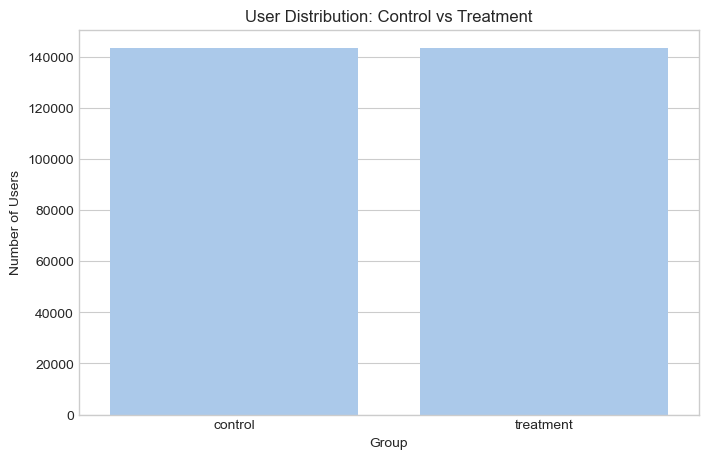

Group counts:
 group
treatment    143397
control      143293
Name: count, dtype: int64


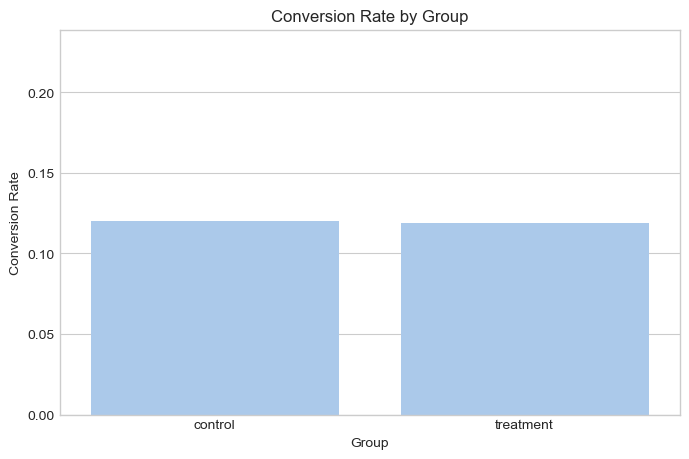

Mean conversion by group:
 group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


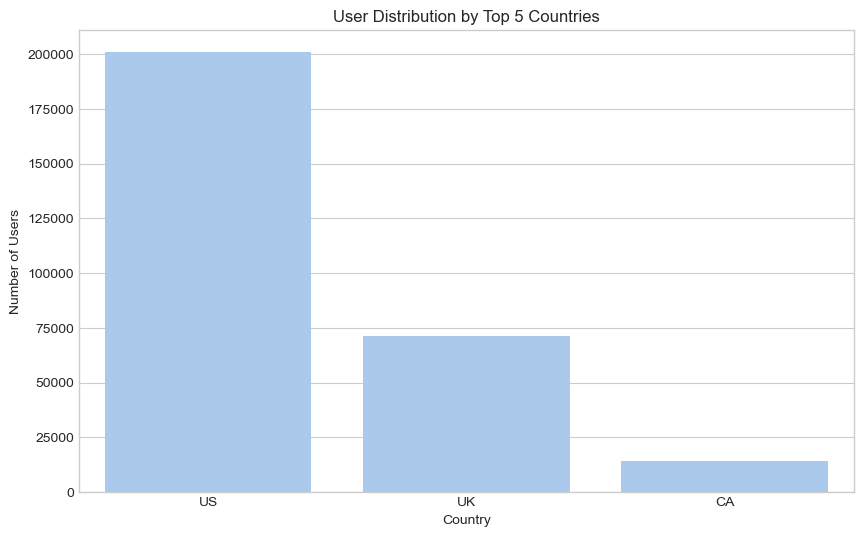

Top 5 countries:
 country
US    200874
UK     71513
CA     14303
Name: count, dtype: int64


In [6]:
# Group distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_cleaned, x='group')
plt.title('User Distribution: Control vs Treatment')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.show()
print("Group counts:\n", df_cleaned['group'].value_counts())

# Conversion rate by group
plt.figure(figsize=(8, 5))
sns.barplot(data=df_cleaned, x='group', y='converted', errorbar=None)
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.ylim(0, df_cleaned['converted'].mean() * 2 if df_cleaned['converted'].mean() > 0 else 0.2) # Dynamic Y-limit
plt.show()
print("Mean conversion by group:\n", df_cleaned.groupby('group')['converted'].mean())

# User distribution by top countries
top_countries = df_cleaned['country'].value_counts().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('User Distribution by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.show()
print("Top 5 countries:\n", top_countries)

# A/B Testing

In [7]:
# Hypotheses: H0: p_new <= p_old, HA: p_new > p_old (one-tailed)
alpha = 0.05 # Significance level

control_group = df_cleaned[df_cleaned['group'] == 'control']
treatment_group = df_cleaned[df_cleaned['group'] == 'treatment']

n_old = len(control_group)
n_new = len(treatment_group)
converted_old_actual = control_group['converted'].sum()
converted_new_actual = treatment_group['converted'].sum()

p_old_actual = converted_old_actual / n_old if n_old > 0 else 0
p_new_actual = converted_new_actual / n_new if n_new > 0 else 0
obs_diff = p_new_actual - p_old_actual

print(f"Control: n={n_old}, converted={converted_old_actual}, rate={p_old_actual:.4f}")
print(f"Treatment: n={n_new}, converted={converted_new_actual}, rate={p_new_actual:.4f}")
print(f"Observed diff (new - old): {obs_diff:.4f}")

Control: n=143293, converted=17220, rate=0.1202
Treatment: n=143397, converted=17025, rate=0.1187
Observed diff (new - old): -0.0014


# Simulation/Bootstrapping

Pooled rate (H0): 0.1194
P-value (simulation): 0.8912


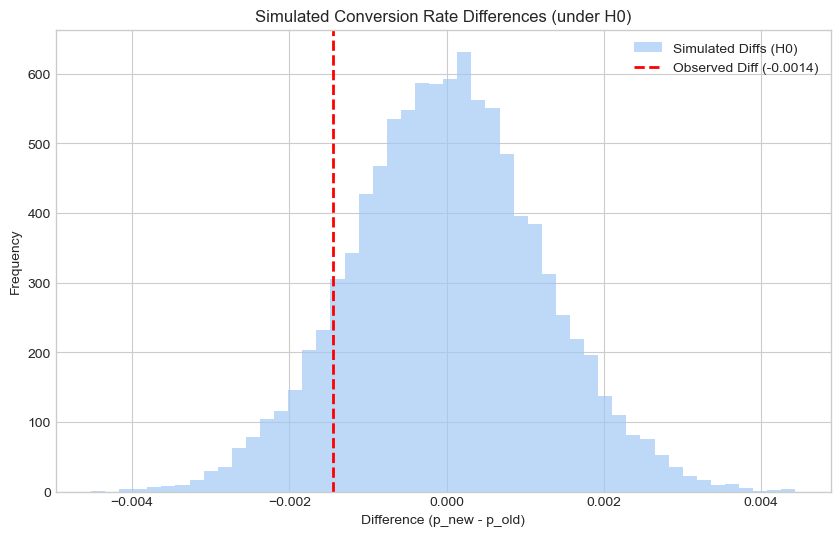

Simulation: Fail to reject H0 (p=0.8912). No strong evidence for new page.


In [8]:
if n_old > 0 and n_new > 0 :
    p_pooled = (converted_old_actual + converted_new_actual) / (n_old + n_new) # Pooled probability under H0
    print(f"Pooled rate (H0): {p_pooled:.4f}")

    n_simulations = 10000
    p_diffs_simulated = []
    # Simulating conversion differences under H0
    for _ in range(n_simulations):
        conversions_old_sim = np.random.binomial(n_old, p_pooled)
        conversions_new_sim = np.random.binomial(n_new, p_pooled)
        p_old_sim = conversions_old_sim / n_old
        p_new_sim = conversions_new_sim / n_new
        p_diffs_simulated.append(p_new_sim - p_old_sim)
    p_diffs_simulated = np.array(p_diffs_simulated)

    p_value_simulation = np.mean(p_diffs_simulated >= obs_diff) # Proportion of simulations >= observed difference
    print(f"P-value (simulation): {p_value_simulation:.4f}")

    #  simulation results
    plt.figure(figsize=(10, 6))
    plt.hist(p_diffs_simulated, bins=50, alpha=0.7, label='Simulated Diffs (H0)')
    plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label=f'Observed Diff ({obs_diff:.4f})')
    plt.title('Simulated Conversion Rate Differences (under H0)')
    plt.xlabel('Difference (p_new - p_old)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    #  from simulation
    if p_value_simulation < alpha:
        print(f"Simulation: Reject H0 (p={p_value_simulation:.4f}). New page may be better.")
    else:
        print(f"Simulation: Fail to reject H0 (p={p_value_simulation:.4f}). No strong evidence for new page.")
else:
    print("Skipping simulation: zero sample size in a group.")
    p_value_simulation = np.nan


# Analytical Approach (Z-test for proportions)

In [10]:
if n_old > 0 and n_new > 0 and converted_old_actual >= 0 and converted_new_actual >=0:
    counts = np.array([converted_new_actual, converted_old_actual]) # New page first for 'larger' alternative
    nobs = np.array([n_new, n_old])
    z_stat, p_value_ztest = sm.stats.proportions_ztest(counts, nobs, alternative='larger')
    print(f"Z-statistic: {z_stat:.4f}, P-value (Z-test): {p_value_ztest:.4f}")

    # Conclusion from Z-test
    if p_value_ztest < alpha:
        print(f"Z-test: Reject H0 (p={p_value_ztest:.4f}). New page is better.")
    else:
        print(f"Z-test: Fail to reject H0 (p={p_value_ztest:.4f}). New page not significantly better.")
else:
    print("Skipping Z-test: zero sample size or invalid conversion counts.")
    z_stat = np.nan
    p_value_ztest = np.nan


Z-statistic: -1.1945, P-value (Z-test): 0.8839
Z-test: Fail to reject H0 (p=0.8839). New page not significantly better.


# Confidence Interval for Difference

In [11]:
if n_old > 0 and n_new > 0:
    #  standard error for the difference in proportions
    se_diff = np.sqrt( (p_new_actual * (1 - p_new_actual) / n_new) + \
                       (p_old_actual * (1 - p_old_actual) / n_old) )
    z_critical = norm.ppf(1 - alpha/2) # Z-critical for 95% CI (two-sided)
    margin_of_error = z_critical * se_diff
    ci_lower = obs_diff - margin_of_error
    ci_upper = obs_diff + margin_of_error

    print(f"Observed difference: {obs_diff:.4f}, SE: {se_diff:.4f}")
    print(f"95% CI for (p_new - p_old): [{ci_lower:.4f}, {ci_upper:.4f}]")
    # Interpret CI
    if ci_lower > 0:
        print("CI: Suggests new page is better (lower bound > 0).")
    elif ci_upper < 0:
        print("CI: Suggests old page is better (upper bound < 0).")
    else:
        print("CI: Contains 0, no significant difference.")
else:
    print("Skipping CI: zero sample size in a group.")
    ci_lower, ci_upper = np.nan, np.nan

Observed difference: -0.0014, SE: 0.0012
95% CI for (p_new - p_old): [-0.0038, 0.0009]
CI: Contains 0, no significant difference.


# A/B Testing: Country-Specific

Analyzing top countries: ['US', 'UK', 'CA']

--- Analysis for Country: US ---
US Control: n=100316, converted=12081, rate=0.1204
US Treatment: n=100558, converted=11898, rate=0.1183
Observed diff for US: -0.0021
Z-stat (US): -1.4581, P-value: 0.9276
Z-test (US): Fail to reject H0.

--- Analysis for Country: UK ---
UK Control: n=35883, converted=4295, rate=0.1197
UK Treatment: n=35630, converted=4317, rate=0.1212
Observed diff for UK: 0.0015
Z-stat (UK): 0.6028, P-value: 0.2733
Z-test (UK): Fail to reject H0.

--- Analysis for Country: CA ---
CA Control: n=7094, converted=844, rate=0.1190
CA Treatment: n=7209, converted=810, rate=0.1124
Observed diff for CA: -0.0066
Z-stat (CA): -1.2367, P-value: 0.8919
Z-test (CA): Fail to reject H0.

--- Country-Specific A/B Test Summary ---
  country     p_old     p_new  obs_diff    z_stat   p_value   n_old   n_new  \
0      US  0.120429  0.118320 -0.002110 -1.458129  0.927598  100316  100558   
1      UK  0.119695  0.121162  0.001467  0.602846  0.27

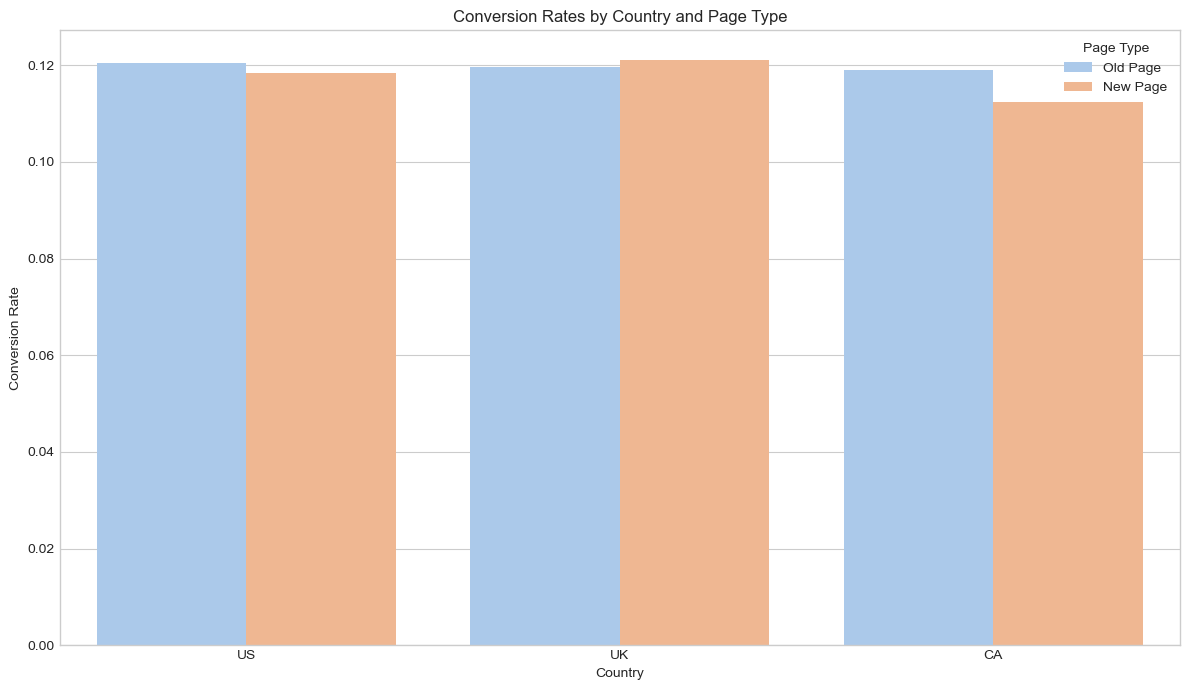

In [ ]:
if 'country' in df_cleaned.columns:
    common_countries = df_cleaned['country'].value_counts().nlargest(3).index.tolist() # Analyzing top 3 countries
    print(f"Analyzing top countries: {common_countries}")
    country_results = []

    for country_code in common_countries:
        print(f"\n--- Analysis for Country: {country_code} ---")
        df_country = df_cleaned[df_cleaned['country'] == country_code]
        
        control_country = df_country[df_country['group'] == 'control']
        treatment_country = df_country[df_country['group'] == 'treatment']

        n_old_country = len(control_country)
        n_new_country = len(treatment_country)

        # if any minimum sample size for reliable test
        if n_old_country < 10 or n_new_country < 10:
            print(f"Skipping {country_code}: small sample (n_old={n_old_country}, n_new={n_new_country}).")
            country_results.append({
                'country': country_code, 'p_old': np.nan, 'p_new': np.nan, 'obs_diff': np.nan,
                'z_stat': np.nan, 'p_value': np.nan, 'n_old': n_old_country, 'n_new': n_new_country,
                'significant': 'N/A (Small Sample)'
            })
            continue 

        converted_old_country = control_country['converted'].sum()
        converted_new_country = treatment_country['converted'].sum()

        p_old_country = converted_old_country / n_old_country
        p_new_country = converted_new_country / n_new_country
        obs_diff_country = p_new_country - p_old_country

        print(f"{country_code} Control: n={n_old_country}, converted={converted_old_country}, rate={p_old_country:.4f}")
        print(f"{country_code} Treatment: n={n_new_country}, converted={converted_new_country}, rate={p_new_country:.4f}")
        print(f"Observed diff for {country_code}: {obs_diff_country:.4f}")

        try:
            # Z-test for this country
            counts_country = np.array([converted_new_country, converted_old_country])
            nobs_country = np.array([n_new_country, n_old_country])
            z_stat_country, p_value_ztest_country = sm.stats.proportions_ztest(counts_country, nobs_country, alternative='larger')
            print(f"Z-stat ({country_code}): {z_stat_country:.4f}, P-value: {p_value_ztest_country:.4f}")
            
            significant_country = p_value_ztest_country < alpha
            print(f"Z-test ({country_code}): {'Reject H0' if significant_country else 'Fail to reject H0'}.")
            
            country_results.append({
                'country': country_code, 'p_old': p_old_country, 'p_new': p_new_country,
                'obs_diff': obs_diff_country, 'z_stat': z_stat_country, 'p_value': p_value_ztest_country,
                'n_old': n_old_country, 'n_new': n_new_country, 'significant': significant_country
            })
        except Exception as e: # Catch any errors during Z-test
            print(f"Error for {country_code}: {e}")
            country_results.append({
                'country': country_code, 'p_old': p_old_country, 'p_new': p_new_country,
                'obs_diff': obs_diff_country, 'z_stat': np.nan, 'p_value': np.nan,
                'n_old': n_old_country, 'n_new': n_new_country, 'significant': 'Error'
            })

    if country_results:
        df_country_summary = pd.DataFrame(country_results)
        print("\n--- Country-Specific A/B Test Summary ---")
        print(df_country_summary)

        #  country-specific conversion rates if data is valid
        if not df_country_summary[['p_old', 'p_new']].isnull().all().all():
            df_plot_country = df_country_summary.melt(id_vars=['country'], value_vars=['p_old', 'p_new'],
                                                      var_name='group_type', value_name='conversion_rate')
            df_plot_country['group_type'] = df_plot_country['group_type'].map({'p_old': 'Old Page', 'p_new': 'New Page'})
            
            plt.figure(figsize=(12, 7))
            sns.barplot(data=df_plot_country, x='country', y='conversion_rate', hue='group_type')
            plt.title('Conversion Rates by Country and Page Type')
            plt.xlabel('Country')
            plt.ylabel('Conversion Rate')
            plt.legend(title='Page Type')
            plt.tight_layout()
            plt.show()
        else:
            print("No valid country-specific rates to plot.")
else:
    print("Skipping country-specific analysis: 'country' column missing or no common countries.")



# Summary/Conclusion based on the analysis

In [ ]:
print(f"Alpha (Significance Level): {alpha}")
print(f"Old Page Rate: {p_old_actual:.4f}, New Page Rate: {p_new_actual:.4f}")
print(f"Observed Difference (New - Old): {obs_diff:.4f}")
if not np.isnan(p_value_simulation): print(f"P-value (Simulation): {p_value_simulation:.4f}")
if not np.isnan(p_value_ztest): print(f"P-value (Z-test): {p_value_ztest:.4f}")
if not np.isnan(ci_lower) and not np.isnan(ci_upper): print(f"95% CI for Difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

#  final decision based on Z-test p-value
final_decision_overall = "Fail to reject H0"
if not np.isnan(p_value_ztest) and p_value_ztest < alpha:
    final_decision_overall = "Reject H0"

print(f"\nOverall Conclusion: {final_decision_overall}.")
if not np.isnan(p_value_ztest): #  if any Z-test was performed
    conclusion_text = "have" if final_decision_overall == 'Reject H0' else "do not have"
    print(f"Based on p-value ({p_value_ztest:.4f}), we {conclusion_text} "
          "statistically significant evidence that the new page performs better.")
    if final_decision_overall == "Fail to reject H0":
        if obs_diff < 0:
            print("New page performed slightly worse (not statistically significant).")
        elif obs_diff > 0:
            print("New page performed slightly better (not statistically significant).")
        else:
            print("No difference observed.")
else:
    print("Overall conclusion cannot be drawn (Z-test issues, small sample case).")


Alpha (Significance Level): 0.05
Old Page Rate: 0.1202, New Page Rate: 0.1187
Observed Difference (New - Old): -0.0014
P-value (Simulation): 0.8912
P-value (Z-test): 0.8839
95% CI for Difference: [-0.0038, 0.0009]

Overall Conclusion: Fail to reject H0.
Based on p-value (0.8839), we do not have statistically significant evidence that the new page performs better.
New page performed slightly worse (not statistically significant).
